In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

In [22]:
# Load the dataset
df = pd.read_csv('../Data/selected_features.csv', parse_dates=['Date'], index_col='Date')

# Rename the target column for clarity
df.rename(columns={'Gesamt (Netzlast) [MWh] Berechnete Auflösungen': 'load'}, inplace=True)

# Inspect the data
print(df.head())
print(df.info())

                     hour  dayofyear_cos  dayofweek  dayofweek_sin  \
Date                                                                 
2018-11-01 00:00:00   0.0       0.512371        3.0       0.433884   
2018-11-01 01:00:00   1.0       0.512371        3.0       0.433884   
2018-11-01 02:00:00   2.0       0.512371        3.0       0.433884   
2018-11-01 03:00:00   3.0       0.512371        3.0       0.433884   
2018-11-01 04:00:00   4.0       0.512371        3.0       0.433884   

                     is_workday  hour_cos  date_offset  dayofyear  \
Date                                                                
2018-11-01 00:00:00         1.0  1.000000        781.0      305.0   
2018-11-01 01:00:00         1.0  0.965926        781.0      305.0   
2018-11-01 02:00:00         1.0  0.866025        781.0      305.0   
2018-11-01 03:00:00         1.0  0.707107        781.0      305.0   
2018-11-01 04:00:00         1.0  0.500000        781.0      305.0   

                     Kern

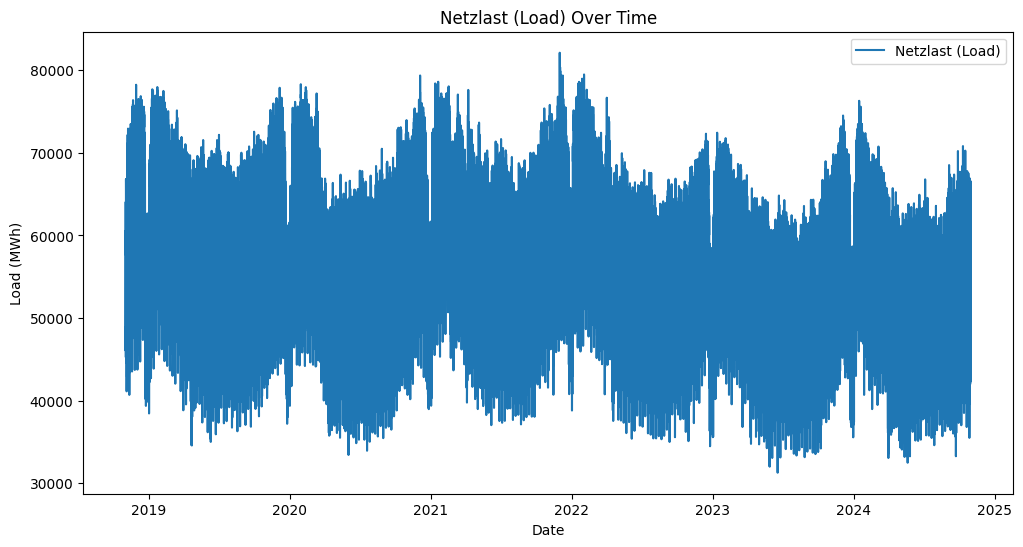

In [23]:
# Plot the target variable (Netzlast/load) over time
plt.figure(figsize=(12, 6))
plt.plot(df['load'], label='Netzlast (Load)')
plt.title('Netzlast (Load) Over Time')
plt.xlabel('Date')
plt.ylabel('Load (MWh)')
plt.legend()
plt.show()

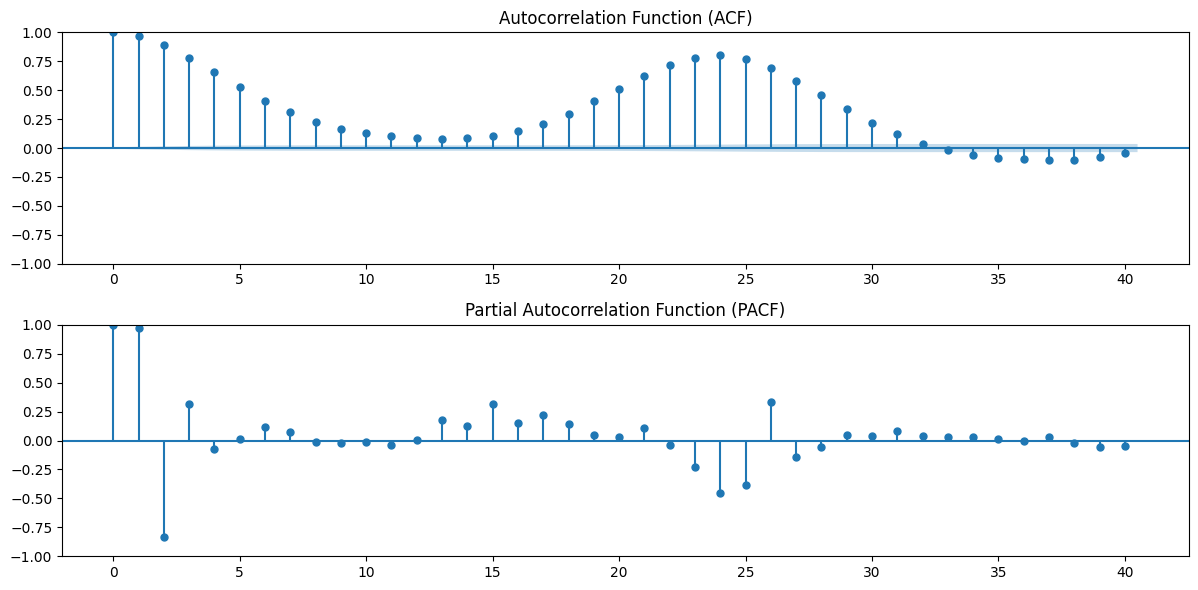

In [52]:
# ACF and PACF plots with significance
plt.figure(figsize=(12, 6))

# ACF plot with significance
plt.subplot(211)
plot_acf(df['load'], lags=40, ax=plt.gca(), alpha=0.05)
plt.title('Autocorrelation Function (ACF)')

# PACF plot with significance
plt.subplot(212)
plot_pacf(df['load'], lags=40, ax=plt.gca(), alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

In [37]:
# Check stationarity using the Augmented Dickey-Fuller test
adf_test = adfuller(df['load'])
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])
if adf_test[1] <= 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary. Differencing might be needed.")

ADF Statistic: -18.039941381794577
p-value: 2.659709903672634e-30
The time series is stationary.


In [100]:
# Ensure the Date column is the index and datetime type
df.index = pd.to_datetime(df.index)

# Split the dataset into training and test sets based on the specific date
train_data = df[(df.index >= pd.Timestamp('2021-09-30')) & (df.index <= pd.Timestamp('2023-09-30'))]
test_data = df[df.index > pd.Timestamp('2023-09-30')]


In [109]:
# List of significant features based on p-values < 0.05
significant_features = [
    'hour_cos', 
    'Steinkohle [MWh] Berechnete Auflösungen', 
    'hour_sin', 
    'Wind Onshore [MWh] Berechnete Auflösungen'
]

# Select the columns from the training data that correspond to significant features
X_selected = train_data[significant_features]


In [110]:
# Train SARIMAX model (example with default order)
sarimax_model = SARIMAX(train_data['load'],
                        exog=X_selected,
                        order=(11, 1, 4),  # (p, d, q)
                        seasonal_order=(1, 1, 1, 24),  # (P, D, Q, s), 12 for monthly seasonality
                        enforce_stationarity=False,
                        n_jobs=-1,
                        enforce_invertibility=False)
sarimax_fitted = sarimax_model.fit(disp=False)

In [99]:
# Print out the model summary
print(sarimax_fitted.summary())

                                       SARIMAX Results                                       
Dep. Variable:                                  load   No. Observations:                17532
Model:             SARIMAX(12, 1, 3)x(1, 1, [1], 24)   Log Likelihood             -140437.412
Date:                               Mon, 13 Jan 2025   AIC                         280918.825
Time:                                       14:38:11   BIC                         281089.727
Sample:                                            0   HQIC                        280975.107
                                             - 17532                                         
Covariance Type:                                 opg                                         
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
hour_cos                    

In [102]:
X_selected_test = test_data[X_selected.columns]


In [103]:
# Assuming you have the same model as before
forecast_steps = len(X_selected_test)  # Number of steps to forecast, based on your test data length

# Get forecast using the trained SARIMAX model
forecast = sarimax_fitted.get_forecast(steps=forecast_steps, exog=X_selected_test)

# Extract forecasted mean and confidence intervals
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

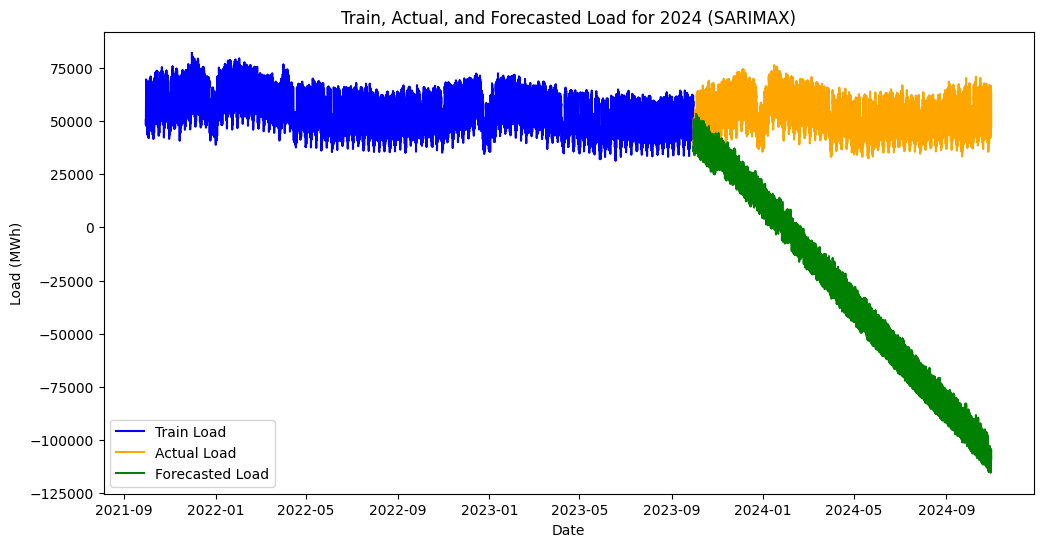

In [104]:
# Plot the training load, actual test load, and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['load'], label='Train Load', color='blue')
plt.plot(test_data.index, test_data['load'], label='Actual Load', color='orange')
plt.plot(test_data.index, forecast_mean, label='Forecasted Load', color='green')
plt.title('Train, Actual, and Forecasted Load for 2024 (SARIMAX)')
plt.xlabel('Date')
plt.ylabel('Load (MWh)')
plt.legend()
plt.show()


In [105]:
# Calculate the MAPE (Mean Absolute Percentage Error)
mape = mean_absolute_percentage_error(test_data['load'], forecast_mean)
print(f'MAPE: {mape}')

MAPE: 1.6385459799923143


In [106]:
# Initialize variables
rolling_predictions = []
train_data_roll = train_data.copy()

# Perform rolling forecast
for t in range(len(test_data)):
    # Forecast the next value (no need to retrain the model each time)
    forecast = sarimax_fitted.get_forecast(steps=1, exog=X_selected_test.iloc[t:t+1])
    forecast_mean = forecast.predicted_mean.iloc[0]  # Use .iloc[0] instead of [0]
    
    # Append the forecast to the list
    rolling_predictions.append(forecast_mean)

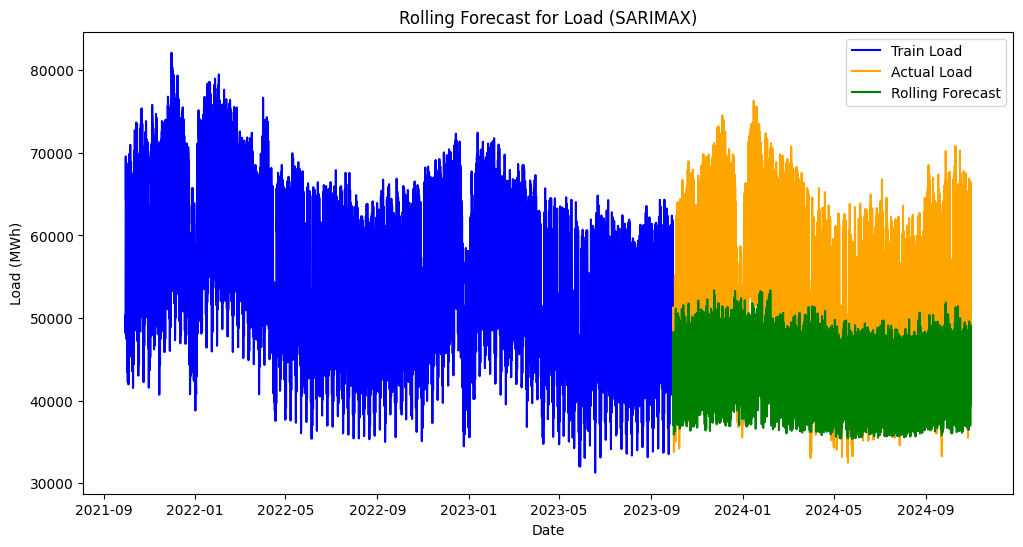

Rolling Forecasted Load for 2024:
[np.float64(37978.75928846623), np.float64(37277.61210836377), np.float64(37035.15691209073), np.float64(37227.3795525869), np.float64(37809.07043569119), np.float64(38757.38357093458), np.float64(40114.06474050842), np.float64(41448.17551895222), np.float64(42720.93457618157), np.float64(44138.307991404945), np.float64(45645.91439091321), np.float64(47033.64246666892), np.float64(47895.616406835026), np.float64(48340.54255969117), np.float64(48290.905529976524), np.float64(47805.69452522788), np.float64(46811.80612627836), np.float64(45716.58226864773), np.float64(44439.20254192504), np.float64(43008.04572976402), np.float64(41453.37111246523), np.float64(39887.91686278583), np.float64(38425.22615434872), np.float64(37307.70454015342), np.float64(36386.99509763268), np.float64(35910.25954393907), np.float64(35958.93301971713), np.float64(36368.196609758365), np.float64(37096.10681576973), np.float64(38191.54112265374), np.float64(39603.79302944301), n

In [107]:
# Plot the actual load and the rolling forecasted values
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['load'], label='Train Load', color='blue')
plt.plot(test_data.index, test_data['load'], label='Actual Load', color='orange')
plt.plot(test_data.index, rolling_predictions, label='Rolling Forecast', color='green')
plt.title('Rolling Forecast for Load (SARIMAX)')
plt.xlabel('Date')
plt.ylabel('Load (MWh)')
plt.legend()
plt.show()

# Print out the rolling predictions
print("Rolling Forecasted Load for 2024:")
print(rolling_predictions)


In [108]:
# Calculate MAPE using the sklearn function
mape = mean_absolute_percentage_error(test_data['load'].iloc[:len(rolling_predictions)], rolling_predictions)

# Print MAPE
print(f"MAPE of the Rolling Forecast: {mape * 100:.2f}%")

MAPE of the Rolling Forecast: 17.82%
